In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from skimage import io, transform
import math
import numpy as np
from os import listdir

In [2]:
torch.cuda.set_device(1)

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(inplanes, planes, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        #self.downsample = downsample
        #self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        #if self.downsample is not None:
        #    residual = self.downsample(x)

        out += residual


        return out


In [4]:
class ResNet(nn.Module):
    def __init__(self):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.prelu1 = nn.PReLU()
        
        self.layer1 = BasicBlock(64, 64)
        self.layer2 = BasicBlock(64, 64)
        self.layer3 = BasicBlock(64, 64)
        self.layer4 = BasicBlock(64, 64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.shuffle1 = nn.PixelShuffle(2)
        self.prelu2 = nn.PReLU()
        
        self.conv4 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.shuffle2 = nn.PixelShuffle(2)
        self.prelu3 = nn.PReLU()
        
        self.conv5 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1,
                               bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

   

    def forward(self, x):
        out = x
        out = self.conv1(out)
        out = self.prelu1(out)
        residual = out

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += residual
        
        out = self.conv3(out)

        out = self.shuffle1(out)
        out = self.prelu2(out)
        
        out = self.conv4(out)
        out = self.shuffle2(out)
        out = self.prelu3(out)
        
        out = self.conv5(out)

        return out

In [5]:
im1 = io.imread('/home/b.lestsov/datasets/test/super-res-test-div2/2012-05-27 19.15.35.jpg')
im1 = transform.resize(im1, (224, 224))
im1 = im1.swapaxes(0, 2)
im1 = (im1-127.5)/128.0
im1 = Variable(torch.Tensor(im1).unsqueeze(0).cuda(), requires_grad=False)

In [6]:
a = ResNet().cuda()

In [7]:
optimizer = optim.Adam(a.parameters(), lr=0.01)

path = "/home/b.lestsov/datasets/SelfExSR/data/BSD100/my/"
hr_path = path+'x2x_HR/'
lr_path = path+'x2x_LR/'
hr_list = sorted(listdir(hr_path))
lr_list = sorted(listdir(lr_path))

for i in range(5):
    ep_loss = 0.0
    for hr, lr in zip(hr_list, lr_list):
        
        lr_im = io.imread(lr_path+lr)
        #lr_im = transform.resize(lr_im, (224, 224))
        lr_im = lr_im.swapaxes(0, 2)
        lr_im = (lr_im-127.5)/128.0
        lr_im = Variable(torch.Tensor(lr_im).unsqueeze(0).cuda(), requires_grad=False)
        
        res_im = a.forward(lr_im)
        
        hr_im = io.imread(hr_path+hr)
        hr_im = transform.resize(hr_im, (res_im.size()[3], res_im.size()[2]), order=2)
        hr_im = hr_im.swapaxes(0, 2)
        hr_im = (hr_im-127.5)/128.0
        hr_im = Variable(torch.Tensor(hr_im).unsqueeze(0).cuda(), requires_grad=False)

        
        
        optimizer.zero_grad()
        crit = nn.MSELoss()
        loss = crit(res_im, hr_im)
        ep_loss += loss
        loss.backward()
        optimizer.step()
        
    print(ep_loss)


Variable containing:
 19282.4824
[torch.cuda.FloatTensor of size 1 (GPU 1)]

Variable containing:
 31.9507
[torch.cuda.FloatTensor of size 1 (GPU 1)]



KeyboardInterrupt: 

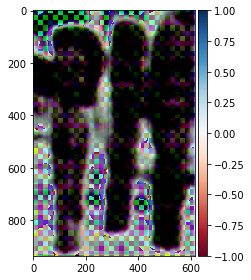

In [8]:
lr_im = io.imread("/home/b.lestsov/datasets/SelfExSR/data/BSD100/my/x2x_LR/img_001_SRF_2_LR.png")
lr_im = lr_im.swapaxes(0, 2)
lr_im = (lr_im-127.5)/128.0
lr_im = Variable(torch.Tensor(lr_im).unsqueeze(0).cuda(), requires_grad=False)

res_im = a.forward(lr_im)

hr_im = io.imread("/home/b.lestsov/datasets/SelfExSR/data/BSD100/my/x2x_HR/img_001_SRF_2_HR.png")
hr_im = transform.resize(hr_im, (res_im.data.size()[3], res_im.data.size()[2]), order=2)

res_im = res_im.data.cpu().numpy()
res_im = res_im[0].swapaxes(0, 2).clip(-1, 1)
io.imshow(res_im)
plt.show()

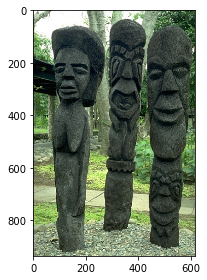

In [16]:
io.imshow(hr_im)
plt.show()